In [1]:
import sys
import os
import json
sys.path.append("../")
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from TorchInversion.propagators import Acoustic_Simulation
from TorchInversion.utils import source_wavelet,set_damp,dictToObj,numpy2tensor,numpy2list,list2numpy
from TorchInversion.plots import plot_model,plot_wavelet,plot_dampRegion,plot_observeSystem,wiggle
from TorchInversion.gradient_precond import grad_precond
from TorchInversion.optimizer import Optimization

### model setup

In [2]:
save_path = "./data/02_LayerModel/AD"

if not os.path.exists(os.path.join(save_path,"model/Initial")):
    os.makedirs(os.path.join(save_path,"model/Initial"))

if not os.path.exists(os.path.join(save_path,"obs/figure")):
    os.makedirs(os.path.join(save_path,"obs/figure"))

if not os.path.exists(os.path.join(save_path,"syn/figure")):
    os.makedirs(os.path.join(save_path,"syn/figure"))
    
if not os.path.exists(os.path.join(save_path,"inv/model")):
    os.makedirs(os.path.join(save_path,"inv/model"))
    
if not os.path.exists(os.path.join(save_path,"inv/grad")):
    os.makedirs(os.path.join(save_path,"inv/grad"))

In [3]:
#######################################
#              模型设置
#######################################
# Model parameters
nx , ny = [100, 200]
nt , dt = [1000, 0.002]
pml, fs   = [30,  1]
nx_pml = nx+2*pml
ny_pml = ny+2*pml
dx, dy = [30, 30]

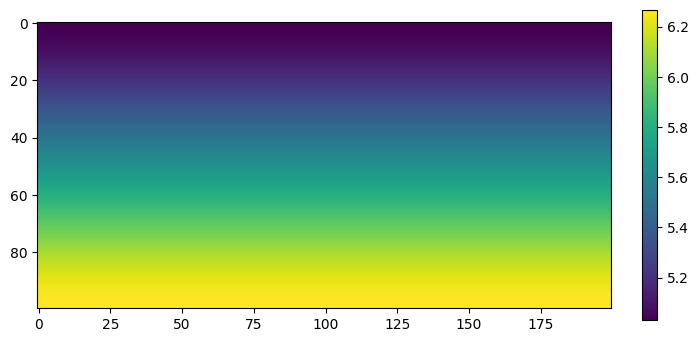

In [4]:
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter
def step_profile(x_range, y_range, step):
    y_step1 = np.round(np.arange(y_range[0], y_range[1]+step, step)/step) * step
    vp_step1 = y_step1/(y_range[1]-y_range[0]) * (6.5-5) + 5
    vs_step1 = y_step1/(y_range[1]-y_range[0]) * (4.48-3.46) + 3.46
    rho_step1 = y_step1/(y_range[1]-y_range[0]) * (3.32-2.72) + 2.72
    
    y_step2 = y_step1 + (y_step1[1] - y_step1[0] - step/5)
    vp_step2 = vp_step1
    vs_step2 = vs_step1
    rho_step2 = rho_step1

    idy = np.argsort(np.hstack([y_step1, y_step2]))
    y_step = np.hstack([y_step1, y_step2])[idy]
    vp_step = np.hstack([vp_step1, vp_step2])[idy]
    vs_step = np.hstack([vs_step1, vs_step2])[idy]
    rho_step = np.hstack([rho_step1, rho_step2])[idy]
    vp_step[-1:] = vp_step[-2]
    vs_step[-1:] = vs_step[-2]
    rho_step[-1:] = rho_step[-2]
    
    return y_step, vp_step, vs_step, rho_step

def build_layer_model(x, y, step):
    y_step, vp_step, vs_step, rho_step = step_profile([x[0], x[-1]], [y[0], y[-1]], step)

    vp = interp1d(y_step, vp_step, kind='slinear')(y)
    vs = interp1d(y_step, vs_step, kind='slinear')(y)
    rho = interp1d(y_step, rho_step, kind='slinear')(y)
    
    vp = np.tile(vp[np.newaxis,:], [len(x),1])
    vs = np.tile(vs[np.newaxis,:], [len(x),1])
    rho = np.tile(rho[np.newaxis,:], [len(x),1])
    
    model = {}
    model['vp'] = vp
    model['vs'] = vs
    model['rho'] = rho
    model['x'] = x
    model['y'] = y
    model['dx'] = x[1] - x[0]
    model['dy'] = y[1] - y[0]
    
    return model

def get_smooth_model(model, ):
    vp = model['vp'].copy()
    vp = gaussian_filter(model['vp'], [10,10], mode='reflect')
    vs = model['vs'].copy()
    vs = gaussian_filter(model['vs'], [10,10], mode='reflect')
    rho = model['rho'].copy()
    rho = gaussian_filter(model['rho'], [10,10], mode='reflect')
    new_model = {}
    new_model['vp'] = vp
    new_model['vs'] = vs
    new_model['rho'] = rho
    new_model['x'] = model['x']
    new_model['y'] = model['y']
    new_model['dx'] = model['dx']
    new_model['dy'] = model['dy']
    return new_model

x = np.arange(0,ny*dy/1000,dx/1000)
y = np.arange(0,nx*dx/1000,dy/1000)

step = 0.5 #km
model = build_layer_model(x, y, step)

smooth_model = get_smooth_model(model)

plt.figure(figsize=(8,6))
plt.imshow(smooth_model['vp'].T)
plt.colorbar(fraction=0.025,pad = 0.05)
plt.show()


In [5]:
v = smooth_model['vp'].T * 1000
rho = np.power(v, 0.25) * 310

v_true = model['vp'].T * 1000
rho_true = np.power(v, 0.25) * 310

In [6]:
#######################################
#             子波设置
#######################################
#Source wavelet
f0 = 15 #Domain frequency
src = source_wavelet(nt, dt, f0, 'Ricker') #Ricker wavelet
st = integrate.cumtrapz(src, axis=-1, initial=0) #Integrate
tlist = np.arange(nt)*dt

#######################################
#              吸收边界设置
#######################################
#PML coefficient
vmin = v_true.min()
vmax = v_true.max()
damp_global = set_damp(vmax,nx_pml,ny_pml,pml,dx)

#######################################
#              炮和检波器设置
#######################################
model_true = json.load(open(os.path.join(save_path,"model/model_true.json")))
model_true = dictToObj(model_true)
# Source location
src_x = list2numpy(model_true.src_x)
src_y = list2numpy(model_true.src_y)
src_n = model_true.src_n
#Receiver location
rcv_x = list2numpy(model_true.rcv_x)
rcv_y = list2numpy(model_true.rcv_y)
rcv_n = model_true.rcv_n

In [7]:
#######################################
#              参数整理
#######################################
# modeling parameters
param = {
    "nx":nx,"ny":ny,
    "dx":dx,"dy":dy,
    "nt":nt,"dt":dt,
    "pml":pml,"fs":fs,
    "nx_pml":nx_pml,"ny_pml":ny_pml,
    "vmax":vmax,"vmin":vmin
}
param = dictToObj(param)

# velocity model
vel_model ={
    "v":v,
    "rho":rho,
    "damp_global":damp_global
}
vel_model= dictToObj(vel_model)

# source
acoustic_src = {
    "src_x":src_x,
    "src_y":src_y,
    "src_n":src_n,
    "stf_val":st,
    "stf_t":tlist
}

acoustic_src = dictToObj(acoustic_src)

# receiver
acoustic_rcv = {
    'rcv_x':rcv_x,
    'rcv_y':rcv_y,
    'rcv_n':rcv_n
}
acoustic_rcv = dictToObj(acoustic_rcv)


In [8]:
import json 
param_save = {
    "nx":nx,"ny":ny,
    "dx":dx,"dy":dy,
    "nt":nt,"dt":dt,
    "pml":pml,"fs":fs,
    "nx_pml":nx_pml,"ny_pml":ny_pml,
}
model_save={
    "v":numpy2list(v),
    "rho":numpy2list(rho),
    "damp_global":numpy2list(damp_global),
    "src_x":numpy2list(src_x),
    "src_y":numpy2list(src_y),
    "src_n":src_n,
    "stf_val":numpy2list(st),
    "stf_t":numpy2list(tlist),
    'rcv_x':numpy2list(rcv_x),
    'rcv_y':numpy2list(rcv_y),
    'rcv_n':rcv_n
}
with open(os.path.join(save_path,"model/param_init.json"),'w') as f:
    json.dump(param_save,f)
with open(os.path.join(save_path,"model/model_init.json"),'w') as f:
    json.dump(model_save,f)


# np.savetxt(os.path.join(save_path,"model/v_true.txt"),v_true)
# np.savetxt(os.path.join(save_path,"model/rho_true.txt"),rho_true)
# np.savetxt(os.path.join(save_path,"model/v_init.txt"),v)
# np.savetxt(os.path.join(save_path,"model/rho_init.txt"),rho)
# rcv = np.vstack((rcv_x,rcv_y))*dx
# src = np.vstack((src_x-pml,src_y-pml))*dx
# np.savetxt(os.path.join(save_path,"model/rcv.txt"),rcv)
# np.savetxt(os.path.join(save_path,"model/src.txt"),src)

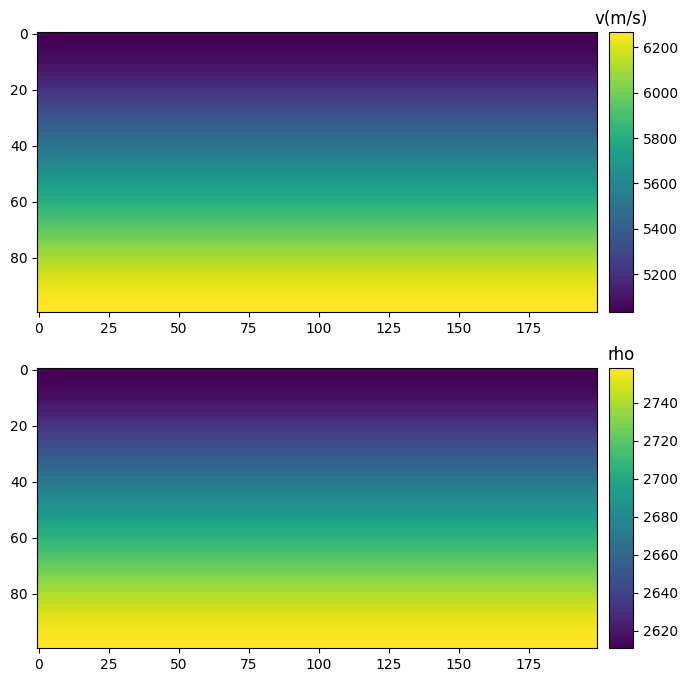

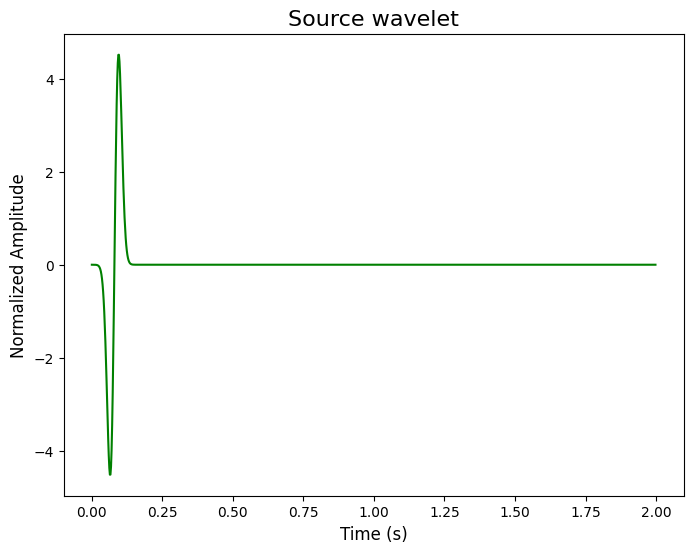

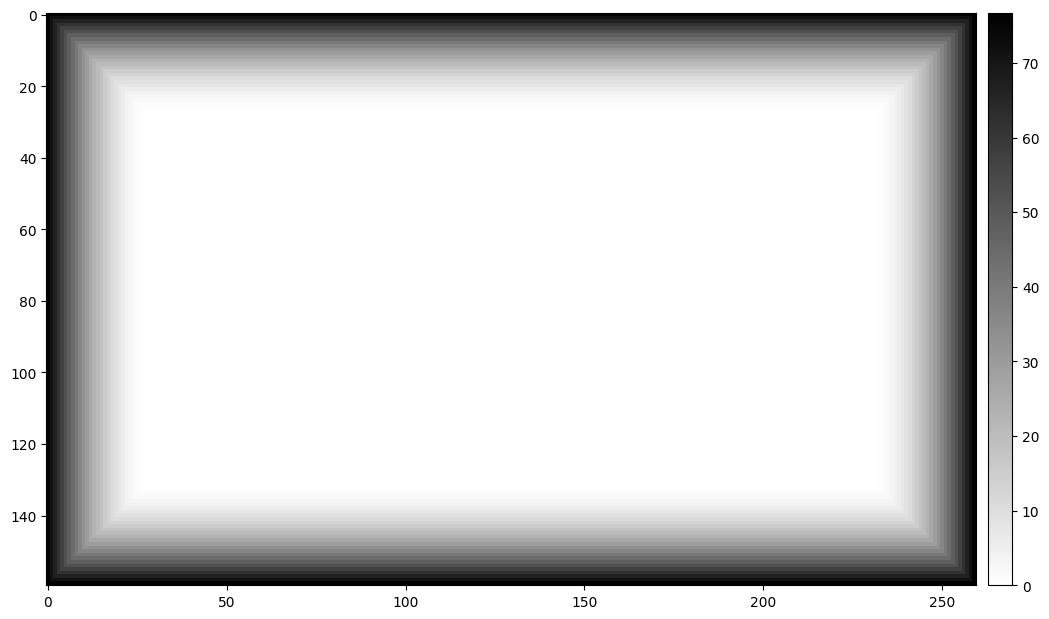

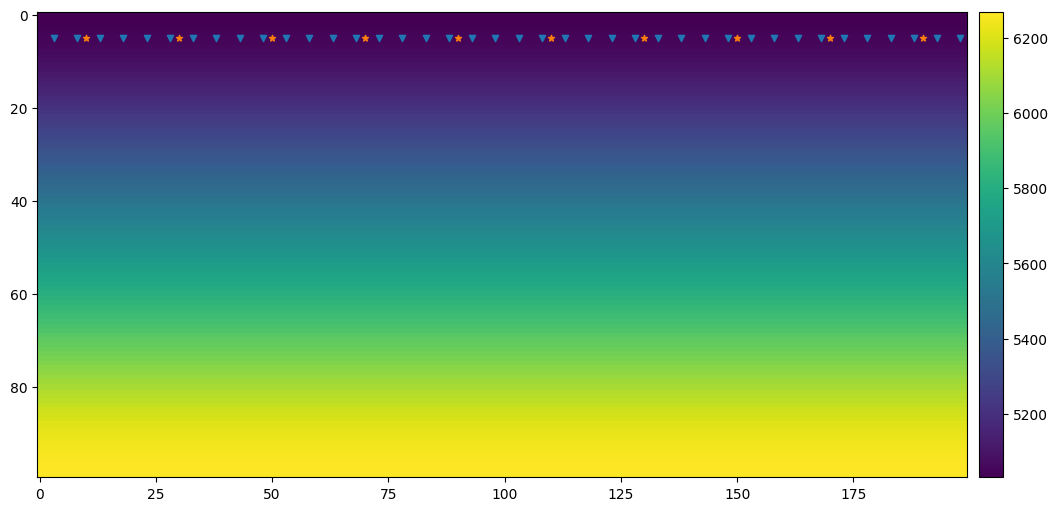

In [9]:
#Plot
plot_model(vel_model,save_path=os.path.join(save_path,"model/Initial/model_init.png"),show=True)
plot_wavelet(acoustic_src,save_path=os.path.join(save_path,"model/Initial/ricker.png"),show=True)
plot_dampRegion(vel_model,save_path=os.path.join(save_path,"model/Initial/damp_global.png"),show=True)
plot_observeSystem(param,vel_model,acoustic_src,acoustic_rcv,save_path=os.path.join(save_path,"model/Initial/observed_system.png"),show=True)

In [ ]:
grad_param = {
    "grad_mute":0,
    "grad_smooth":0,
    "marine_or_land":"land",
}
grad_param = dictToObj(grad_param)

In [ ]:
#######################################
#         Gradient Calculation
#######################################
device = "cuda:0"
obs_data = np.load(os.path.join(save_path,"obs/obs.npz"))["obs_data"]
acoustic_sim = Acoustic_Simulation(param,vel_model,acoustic_src,acoustic_rcv,obs_data=obs_data,device=device)
# input model
rho = numpy2tensor(rho).to(device)
v = numpy2tensor(v).to(device)
v.requires_grad = True
loss,grads,csg,forw = acoustic_sim.inversion(v,rho)
# save the result
if device == 'cpu':
    csg = csg.numpy()
    v = v.detach().numpy()
    rho = rho.detach().numpy()
    
    forw = forw.numpy()
    loss = loss.numpy().tolist()
    grads = -grads.numpy()/2
    # grads = grads/v
    grads = grad_precond(param,grads,forw,grad_mute=grad_param.grad_mute,grad_smooth=grad_param.grad_smooth,marine_or_land=grad_param.marine_or_land)
else:
    csg = csg.numpy()
    v = v.cpu().detach().numpy()
    rho = rho.cpu().detach().numpy()
    
    forw = forw.cpu().numpy()
    loss = loss.cpu().numpy().tolist()
    grads = -grads.cpu().numpy()/2
    # grads = grads/v
    grads = grad_precond(param,grads,forw,grad_mute=grad_param.grad_mute,grad_smooth=grad_param.grad_smooth,marine_or_land=grad_param.marine_or_land)

np.savez(os.path.join(save_path,"syn/syn.npz"),obs_data = csg)
np.savetxt(os.path.join(save_path,"inv/grad/0.txt"),grads)
# for i in range(src_n):
#     wiggle(csg[i],np.arange(nt)*dt,save_path=os.path.join(save_path,"syn/figure/s{}_syn.png".format(i)))
loss

In [ ]:
plt.subplot()
plt.imshow(grads,cmap="jet_r")
plt.colorbar(fraction=0.025,pad = 0.05)
plt.savefig(os.path.join(save_path,"inv/grad/0.png"))
plt.show()

In [ ]:
plt.imshow(forw)
plt.colorbar(fraction=0.025,pad = 0.05)
plt.show()

In [ ]:
# iteration
iteration = 100
loss_lists = [loss]

# optimizer
optim = Optimization(niter_max=iteration,conv=1e-6,method='CG',debug=False)
optim.nls_max = 30
optim.alpha = 0.1
min_v = 5000
max_v = 6500
grad_pre = grads

pbar = tqdm(range(1,iteration+1),position=0)
for i in pbar:
    # update the velocity
    v = optim.iterate(v,loss,grads,grad_pre)
    v = np.clip(v,a_min=min_v,a_max=max_v)
    v = v.reshape(nx,ny)
    # update the density
    rho = np.power(v, 0.25) * 310
    if(optim.FLAG == 'GRAD'):
        # recalculate the gradient
        rho = numpy2tensor(rho).to(device)
        v = numpy2tensor(v).to(device)
        v.requires_grad = True
        loss,grads,_,forw = acoustic_sim.inversion(v,rho)
        
        # save the result
        if device == 'cpu':
            v = v.detach().numpy()
            forw = forw.numpy()
            loss = loss.numpy()
            grads = -grads.numpy()/2
            # grads = grads/v
            grads = grad_precond(param,grads,forw,grad_smooth=0)
        else:
            v = v.cpu().detach().numpy()
            forw = forw.numpy()
            loss = loss.cpu().numpy()
            grads = -grads.cpu().numpy()/2
            # grads = grads/v
            grads = grad_precond(param,grads,forw,grad_smooth=0)

        # save the last grad
        grad_pre = grads.copy()
        loss_lists.append(loss)
    
    if (i-1)%5==0:
        plt.figure()
        plt.imshow(v)
        plt.colorbar(fraction=0.025,pad = 0.05)
        plt.title("Iter {}".format(i-1))
        plt.savefig(os.path.join(save_path,"inv/model/{}.png".format(i)))
        plt.close()
        
        plt.figure()
        plt.imshow(grads,cmap="jet_r")
        plt.colorbar(fraction=0.025,pad = 0.05)
        plt.title("Iter {}".format(i-1))
        plt.savefig(os.path.join(save_path,"inv/grad/{}.png".format(i)))
        plt.close()
    pbar.set_description("Iter:{},Loss:{}".format(i,loss))

In [ ]:
plt.savetxt(os.path.join(save_path,"inv_model.txt"),v)